# Example 01 - Maximize C_l / C_d
- pyfoil: https://github.com/nathanrooy/aerodynamic-shape-optimization
- simulated annealing: https://github.com/nathanrooy/simulated-annealing

In [1]:
from scipy.optimize import minimize
from simulated_annealing import sa
from pso import pso_simple
from matplotlib import pyplot as plt

from pyfoil.parametric_airfoil import *
from pyfoil.xfoil import *

In [2]:
# lets read in the naca0012 airfoil geometry
target_airfoil = []
with open('naca0012.txt','r') as foil_txt:
    for i, row in enumerate(foil_txt.readlines()):
        if len(row.split())==2: 
            x, y = row.split()
            target_airfoil.append([float(x), float(y)])    
            
target_airfoil = np.asarray(target_airfoil)

In [3]:
# reverse fit the parametric airfoil to the naca0012
xpts = np.linspace(0,0.99,100)
initial_airfoil = [0.03, 0.76, 0.08, 0.48, 0.13, 0.15, 0.12, 0.15, -0.08, 0.37, -0.01, 0.69, 0.04]

In [4]:
# create cost function
def shape_match(control_pts, xpts=xpts, ta=target_airfoil):
    ca = np.array(bezier_airfoil(xpts, munge_ctlpts(control_pts, 3, 3)))
    try:
        return 1000 * np.sum(abs(ca[:,0] - ta[:,0]) + abs(ca[:,1] - ta[:,1]))
    except:
        return 1e10

In [5]:
# minimize this thing
res = minimize(shape_match, initial_airfoil, method='Powell', tol=1e-10, options={'disp': True, 'maxiter':10000})

Optimization terminated successfully.
         Current function value: 31.505106
         Iterations: 65
         Function evaluations: 37541


In [6]:
res.fun

31.50510557112153

In [7]:
res.x

array([ 0.02421917,  0.85743828,  0.02209078,  0.44159938,  0.06038287,
        0.15018644,  0.05948909,  0.11880418, -0.05293774,  0.31333506,
       -0.06417121,  0.71570799, -0.03953462])

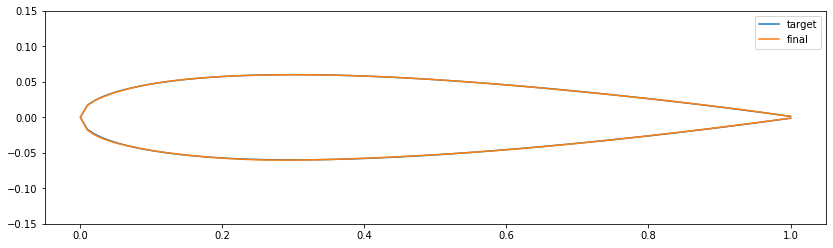

In [8]:
# lets plot the solution

matched_airfoil = np.array(bezier_airfoil(xpts, munge_ctlpts(res.x, 3, 3)))
x0, y0 = zip(*target_airfoil)
x1, y1 = zip(*matched_airfoil)

fig, ax = plt.subplots(figsize=(14,5))
plt.plot(x0, y0, label='target')
plt.plot(x1, y1, label='final')

ax.set_aspect('equal')
plt.ylim(-0.15,0.15)
plt.legend()
plt.show()

In [9]:
# the initial airfoil used panels with constant spacing
# lets be smart and change this to cosine spacing
# while using the control points we just solved for.

num_panels = 60
num_pts = num_panels + 1

x_rad = np.linspace(0, pi, num_pts)
x_cos = (np.cos(x_rad) / 2) + 0.5
x_cos = x_cos[1:]

# matched airfoil with cosine spacing
initial_airfoil = np.array(bezier_airfoil(x_cos, munge_ctlpts(res.x, 3, 3)))

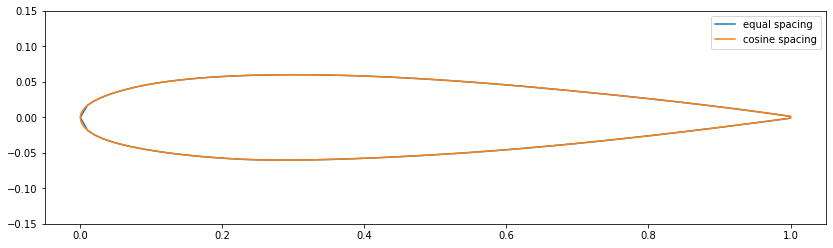

In [10]:
# final sanity check

x0, y0 = zip(*matched_airfoil)
x1, y1 = zip(*initial_airfoil)

fig, ax = plt.subplots(figsize=(14,5))
plt.plot(x0, y0, label='equal spacing')
plt.plot(x1, y1, label='cosine spacing')

ax.set_aspect('equal')
plt.ylim(-0.15,0.15)
plt.legend()
plt.show()

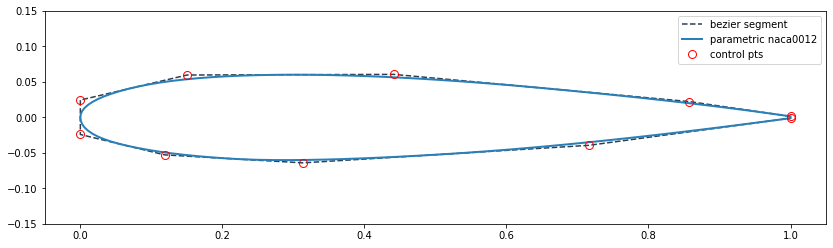

In [11]:
# plot final airfoil with control points
x0, y0=zip(*np.array(munge_ctlpts(res.x, 3, 3)))
x1, y1 = zip(*initial_airfoil)


fig, ax = plt.subplots(figsize=(14,5))
plt.plot(x0, y0, color='#2c3e50', linewidth=1.5, linestyle='--', label='bezier segment')
plt.plot(x1, y1, color='#2980b9', label='parametric naca0012', linewidth=2)
plt.plot(x0, y0, 'o', mfc='none', mec='r', markersize=8, label='control pts')

ax.set_aspect('equal')
plt.ylim(-0.15, 0.15)
plt.legend()

plt.show()

In [12]:
def cost_function(x, x_coords=x_cos):
    airfoil_file = 'airfoil.txt'
    
    try:
        # munge x-vector into bezier format
        control_pts = munge_ctlpts(x, 3, 3)

        # generate new airfoil
        curve = bezier_airfoil(x_coords, control_pts)

        # output airfoil to csv
        with open(airfoil_file,'w') as out_file:
            out_file.write('x,y\n')
            for item in curve:
                out_file.write(f'{item[0]},{item[1]}\n')

        # run xfoil and collect results
        results_dict = run_xfoil()
        
        # determine cost
        cost = results_dict['cl'] / results_dict['cd']
        if results_dict['cl'] < 0: cost = 0.01
        
    except:
        cost = 0.01
    
    # remove airfoil file
    os.system(f'rm -rf {airfoil_file}')

    print(f'> cl/cd={cost:0.4f} -> cost_func={1000.0 / cost:0.4f}')
    
    return 1000.0 / cost

In [18]:
opt = sa.minimize(cost_function, res.x, opt_mode = 'continuous', step_max=500, t_max=2.5, t_min=0, damping=0.01) 

> cl/cd=0.4283 -> cost_func=2334.7826
> cl/cd=0.0100 -> cost_func=100000.0000
> cl/cd=3.3603 -> cost_func=297.5904
> cl/cd=3.2727 -> cost_func=305.5556
> cl/cd=0.0100 -> cost_func=100000.0000
> cl/cd=0.0100 -> cost_func=100000.0000
> cl/cd=0.0100 -> cost_func=100000.0000
> cl/cd=0.0100 -> cost_func=100000.0000
> cl/cd=0.0100 -> cost_func=100000.0000
> cl/cd=0.0100 -> cost_func=100000.0000
> cl/cd=5.8641 -> cost_func=170.5298
> cl/cd=7.2593 -> cost_func=137.7551
> cl/cd=0.0100 -> cost_func=100000.0000
> cl/cd=1.3910 -> cost_func=718.9189
> cl/cd=0.0100 -> cost_func=100000.0000
> cl/cd=4.2266 -> cost_func=236.5942
> cl/cd=3.5626 -> cost_func=280.6950
> cl/cd=8.4861 -> cost_func=117.8392
> cl/cd=3.8614 -> cost_func=258.9744
> cl/cd=8.7107 -> cost_func=114.8014
> cl/cd=0.3171 -> cost_func=3153.3333
> cl/cd=7.6228 -> cost_func=131.1850
> cl/cd=1.6777 -> cost_func=596.0396
> cl/cd=3.9748 -> cost_func=251.5837
> cl/cd=3.5513 -> cost_func=281.5900
> cl/cd=1.7488 -> cost_func=571.8182
> cl/cd=1

> cl/cd=0.0100 -> cost_func=100000.0000
> cl/cd=22.4611 -> cost_func=44.5214
> cl/cd=0.0100 -> cost_func=100000.0000
> cl/cd=0.0100 -> cost_func=100000.0000
> cl/cd=0.0100 -> cost_func=100000.0000
> cl/cd=0.0100 -> cost_func=100000.0000
> cl/cd=74.1713 -> cost_func=13.4823
> cl/cd=0.0100 -> cost_func=100000.0000
> cl/cd=0.0100 -> cost_func=100000.0000
> cl/cd=81.4800 -> cost_func=12.2730
> cl/cd=0.0100 -> cost_func=100000.0000
> cl/cd=73.2035 -> cost_func=13.6605
> cl/cd=0.0100 -> cost_func=100000.0000
> cl/cd=0.0100 -> cost_func=100000.0000
> cl/cd=79.9064 -> cost_func=12.5146
> cl/cd=62.6525 -> cost_func=15.9611
> cl/cd=66.2982 -> cost_func=15.0834
> cl/cd=71.7426 -> cost_func=13.9387
> cl/cd=67.6848 -> cost_func=14.7744
> cl/cd=70.4220 -> cost_func=14.2001
> cl/cd=66.5045 -> cost_func=15.0366
> cl/cd=71.4258 -> cost_func=14.0005
> cl/cd=74.7495 -> cost_func=13.3780
> cl/cd=71.8919 -> cost_func=13.9098
> cl/cd=0.0100 -> cost_func=100000.0000
> cl/cd=70.0743 -> cost_func=14.2706
> cl/

> cl/cd=113.1476 -> cost_func=8.8380
> cl/cd=107.9424 -> cost_func=9.2642
> cl/cd=113.0571 -> cost_func=8.8451
> cl/cd=113.2068 -> cost_func=8.8334
> cl/cd=112.4897 -> cost_func=8.8897
> cl/cd=116.1898 -> cost_func=8.6066
> cl/cd=111.9748 -> cost_func=8.9306
> cl/cd=113.0670 -> cost_func=8.8443
> cl/cd=116.3433 -> cost_func=8.5953
> cl/cd=106.4416 -> cost_func=9.3948
> cl/cd=125.6604 -> cost_func=7.9580
> cl/cd=113.6479 -> cost_func=8.7991
> cl/cd=126.5490 -> cost_func=7.9021
> cl/cd=123.6645 -> cost_func=8.0864
> cl/cd=117.1317 -> cost_func=8.5374
> cl/cd=114.4231 -> cost_func=8.7395
> cl/cd=124.5733 -> cost_func=8.0274
> cl/cd=123.1040 -> cost_func=8.1232
> cl/cd=111.9149 -> cost_func=8.9354
> cl/cd=124.7702 -> cost_func=8.0147
> cl/cd=127.3246 -> cost_func=7.8539
> cl/cd=0.0100 -> cost_func=100000.0000
> cl/cd=111.2206 -> cost_func=8.9911
> cl/cd=0.0100 -> cost_func=100000.0000
> cl/cd=0.0100 -> cost_func=100000.0000
> cl/cd=130.5212 -> cost_func=7.6616
> cl/cd=124.1390 -> cost_func

In [19]:
opt.results()

+------------------------ RESULTS -------------------------+

      opt.mode: continuous
cooling sched.: linear additive cooling
       damping: 0.01

  initial temp: 2.5
    final temp: 0.005000
     max steps: 500
    final step: 500

  final energy: 7.228474

+-------------------------- END ---------------------------+


In [20]:
# initial
# note that the initial airfoil did produce just the smallest bit of lift 
# which is why the cost function is greater than zero...
cost_function(opt.x0)

> cl/cd=0.4283 -> cost_func=2334.7826


2334.782608695652

In [21]:
# final
cost_function(opt.best_state)

> cl/cd=138.3418 -> cost_func=7.2285


7.228473581213308

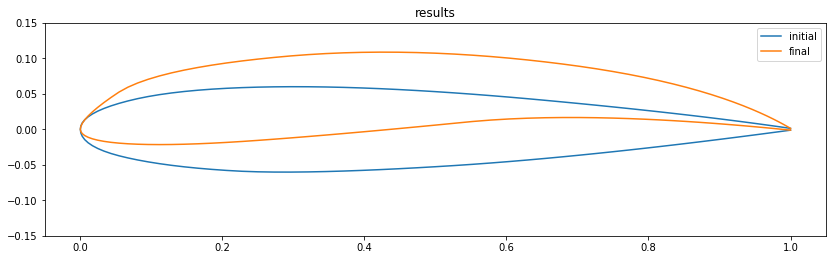

In [22]:
airfoil_initial = bezier_airfoil(x_cos, munge_ctlpts(opt.x0, 3, 3))
airfoil_final   = bezier_airfoil(x_cos, munge_ctlpts(opt.best_state, 3, 3))

fig, ax = plt.subplots(figsize=(14,5))

x_initial, y_initial=zip(*airfoil_initial)
x_final, y_final=zip(*airfoil_final)

plt.plot(x_initial, y_initial, label='initial')
plt.plot(x_final, y_final, label='final')
plt.title('results')

plt.legend()
plt.ylim(-0.15, 0.15)
ax.set_aspect('equal')
plt.show()